In [65]:
"""
Created on Tuesday 1 May 2023
Author: ZAW
"""
#import libraries
import numpy as np
import pandas as pd
import os
from scipy.optimize import curve_fit
import warnings
warnings.simplefilter("ignore")

### Load the subject and stiumuls repect to their speed
path = os.getcwd()
dirname = os.path.dirname(path)
# for HC
data_file = 'data/two_degPD.csv'
# # for PD
#data_file = 'data/PD/one_deg.csv'

data_path = os.path.join(dirname,data_file)
# data = pd.read_csv(data_path)
data= pd.read_csv(data_path)

#import CSV data for stimulus
path_sti = os.getcwd()
dirname_sti = os.path.dirname(path_sti)
data_file_sti = 'data/2_degSti.xlsx'
data_path_sti = os.path.join(dirname_sti,data_file_sti)
rawdata = pd.read_excel(data_path_sti)
data_st = np.array(rawdata[1:],dtype=np.float)
time = data_st[:,1]
position = data_st[:,0]

FirstTrialHC = []

# List of subject codes (e.g. PD001, PD002, etc.)
# subject_codes = ["PD001","PD002","PD003","PD004","PD005","PD006","PD007","PD008","PD009","PD010",
#  "PD011","PD012","PD013","PDN015","PDN017","PDN018","PDN019","PDN022","PD026"]

subject_codes =['PD104','PD106','PD107','PD108','PD109','PD111','PD112','PD119','PD120','PD121',
 'PD122','PD126','PDPY101','PDQE102','PDQE103','PDQE104','PDQE105','PDQE107','PDQE108','PDQE112',
 'PDQE113','PDQE114','PDQE115','PDPW104','PDPW106','PDPW107','PDPW109','PDPW110','PDPW111','PDPW112',
 'PDPW113']

for subject_code in subject_codes:
    ### Load the subject and stiumuls repect to their speed
    path = os.getcwd()
    dirname = os.path.dirname(path)
    # for HC
    data_file = 'data/two_degPD.csv'
    # # for PD
    #data_file = 'data/PD/one_deg.csv'

    data_path = os.path.join(dirname,data_file)
    # data = pd.read_csv(data_path)
    data= pd.read_csv(data_path)
    print('File '+ str(subject_code)+ ' is started.') 
    x_column = f'x2_{subject_code}'
    y_column = f'y2_{subject_code}'

    # Check if both columns exist in the DataFrame before accessing them
    if x_column in data.columns and y_column in data.columns:
        data_hc = data[[x_column, y_column]]
    else:
        print(f"Columns for subject code {subject_code} not found. Skipping...")
        continue

    y_data = data_hc[x_column]
    x_data = data_hc[y_column]

    # data_hc = data[['x1_PD001','y1_PD001']] # change the ID each subject code(e.g PD001 or PD003)
    # y_data = data_hc[data_hc.columns[0]]
    # x_data = data_hc[data_hc.columns[1]]


    # Trigonometric Functions
    # Trigonometric functions

    # Define the function
    def func(x, a, b, c):  #Position as a function of time.
        return a*(2/np.pi)*np.arcsin(np.sin(np.pi*(b*x+c)))

    #initial guesses( This has to change depend on stimulus speed)
    #for 1 degree per second: [10, 0.05, 0]
    #for 2 degrees per second: [10, 0.1, 0]
    #for 4 degrees per second: [10, 0.2, 0]
    #for 6 degrees per second: [10, 0.3, 0]
    #for 8 degrees per second: [10, 0.4, 0]
    InitialGuess = [10, 0.1, 0] # for one degree

    # Perform curve fitting
    popt, pcov = curve_fit(func,position,time, p0=InitialGuess)

    # Extract the optimal values of a, b, and c
    a, b, c = popt
    # print("a =", a)
    # print("b =", b)
    # print("c =", c)

    # Fit the curve
    fit_time = func(y_data,a,b,c)
    # plt.plot(y_data,fit_time)
    # plt.show()

    # Find the residual
    # Different(aka residual)
    diff = x_data - fit_time

    dt_array = np.array(diff)
    dt_array = pd.DataFrame(dt_array,columns=['diff'])
    window_size = 2
    dt_array['Moving_Average'] = dt_array['diff'].rolling(window=window_size).mean()
    #plt.plot(y_data,dt_array['Moving_Average'])
    # create dataframe
    data = {'Time':y_data,'POS':dt_array['Moving_Average']}
    df = pd.DataFrame(data)

    # The whole dataset
    # Plot specific range
    x_start = 5.0
    x_end = 45.00

    # Filter the data points within the disired range using boolean indexing
    mask = (df['Time'] >= x_start) & (df['Time'] <= x_end)
    x_data_range = df.loc[mask]

    data = {'Time':x_data_range['Time'],'POS':x_data_range['POS']}
    df_test = pd.DataFrame(data)

    # Determine the integration window
    def check_sign(x):
        if x > 0:
            return "Positive"
        else:
            return "Negative"
    df_test['Sign'] = df_test['POS'].apply(check_sign)

    # Condition window width 
    def calculate_start_end(row):
        global last_positive, last_negative
        if row['Sign'] == 'Positive':
            if row.name == 0 or df_test.loc[row.name - 1, 'Sign'] != 'Positive':
                last_positive = row['Time']
                return last_positive, '', '', ''
            elif row.name < len(df_test) - 1 and df_test.loc[row.name + 1, 'Sign'] != 'Positive':
                pos_end = row['Time']
                last_positive = ''
                return '', pos_end, '', ''
            else:
                return '', '', '', ''
        elif row['Sign'] == 'Negative':
            if row.name == 0 or df_test.loc[row.name - 1, 'Sign'] != 'Negative':
                last_negative = row['Time']
                return '', '', last_negative, ''
            elif row.name < len(df_test) - 1 and df_test.loc[row.name + 1, 'Sign'] != 'Negative':
                last_negative = row['Time']
                return '', '', '', last_negative
            else:
                return '', '', '', ''
        else:
            return '', '', '', ''

    # Initialize the last positive and negative values to empty strings 
    last_positive = ''
    last_negative = ''

    # Reset the index of the DataFrame
    df_test = df_test.reset_index(drop=True)

    # Apply the custom function to create new columns
    df_test['PosTim_Start'], df_test['PosTim_End'], df_test['NegTim_Start'], df_test['NegTim_End'] = zip(*df_test.apply(calculate_start_end, axis=1))

    # Fill the empty cells with an empty string
    df_test['PosTim_Start'] = df_test['PosTim_Start'].fillna('') 
    df_test['PosTim_End'] = df_test['PosTim_End'].fillna('')
    df_test['NegTim_Start'] = df_test['NegTim_Start'].fillna('')
    df_test['NegTim_End'] = df_test['NegTim_End'].fillna('')

    # Print the resulting dataframe 
    #print(df_test)


    # Positive time start trimming
    # Select the non-empty values in the 'Pos_Start' column
    pos_start_values = df_test.loc[df_test['PosTim_Start'] != '', 'PosTim_Start'].values

    # Round the values in the 'Pos_Start' column to two decimal places
    rounded_pos_start_values = []
    for value in pos_start_values:
        rounded_pos_start_values.append(round(value - 0.003, 2))

    # Convert the list of rounded values back to a NumPy array
    postim_start_values = np.array(rounded_pos_start_values)

    # Print the non-empty values
    #print(postim_start_values)


    # Positive time end triming
    # Select the non-empty values in the 'Pos_End' column
    pos_end_values = df_test.loc[df_test['PosTim_End'] != '', 'PosTim_End'].values

    #Round the values in the 'Pos_End' column to two decimal places
    rounded_pos_end_values = []
    for value in pos_end_values:
        rounded_pos_end_values.append(round(value - 0.02, 2))

    # Convert the list of rounded values back to a NumPy array
    postim_end_values = np.array(rounded_pos_end_values)

    # Print the non-empty values
    #print(postim_end_values)


    # Reload the raw data for mapping
    data = data_hc.rename(columns={data_hc.columns.values[0]:"Position",
                                data_hc.columns.values[1]:'Time'})


    # Map the start positive time to POS in raw data
    # Create a dictionary from the mapping list
    mapping_list = postim_start_values

    # Map the values to the 'POS' column in raw
    mapped_posSt = data.loc[data['Position'].isin(mapping_list),'Time']


    # Map the end positive time to POS in raw data
    # Create a dictionary from the mapping list
    mapping_list = postim_end_values

    # Map the values to the 'POS' column in raw
    mapped_posEnd = data.loc[data['Position'].isin(mapping_list),'Time']


    # Velocity param positive dataframe
    # # column miss match
    # Check lengths and truncate longer column 
    if len(postim_start_values) > len(mapped_posSt): 
        postim_start_values = postim_start_values[:len(mapped_posSt)] 
    elif len(mapped_posSt) > len(postim_start_values):
        mapped_posSt = mapped_posSt[:len(postim_start_values)]      

    # Now columns have equal length 
    data_param = {'positive_x1':postim_start_values,'positive_y1':mapped_posSt}             
    param_vel_start = pd.DataFrame(data_param)

    data_param= {'positive_x2':postim_end_values,'positive_y2':mapped_posEnd}
    param_vel_end = pd.DataFrame(data_param)

    # Reset the indices of the DataFrames
    param_vel_start = param_vel_start.reset_index(drop=True)
    param_vel_end = param_vel_end.reset_index(drop=True)

    # Concatenate the DataFrames horizontally
    param_vel_positive_final = pd.concat([param_vel_start,param_vel_end],axis=1)
    #param_vel_positive_final['Del_X'] = param_vel_positive_final['positive_x2'] - param_vel_positive_final['positive_x1']

    param_vel_positive_final['Del_X'] = (param_vel_positive_final['positive_x2'] - 
                                        param_vel_positive_final['positive_x1']).where(~param_vel_positive_final['positive_x2'].isnull(), np.nan)



    # # Remove short duration SWJ from 50 ms to 400 ms
    param_vel_positive_final = param_vel_positive_final[(param_vel_positive_final['Del_X'] > 0.4) & 
                                                        (param_vel_positive_final['Del_X'] < 2.00)]
    
   # Condition
    param_vel_positive_final['Condition'] = param_vel_positive_final['positive_x2'] - param_vel_positive_final['positive_x1']
    param_vel_positive_final['Condition'] =abs(param_vel_positive_final['Condition'])
    param_vel_positive_final = param_vel_positive_final[param_vel_positive_final['Condition'] > 0.72]


    # iterate over the rows of the dataframe
    prev_positive_x2 = None
    for i, row in param_vel_positive_final.iterrows():
        # check if this is not the first row
        if prev_positive_x2 is not None:
            # check if positive_x1 is lower than the previous positive_x2
            if row['positive_x1'] < prev_positive_x2:
                # remove this row from the dataframe
                param_vel_positive_final = param_vel_positive_final.drop(i)
            else:
                # update prev_positive_x2 if positive_x1 is greater than or equal to prev_positive_x2
                prev_positive_x2 = row['positive_x2']
        else:
            # initialize prev_positive_x2 with the first row value
            prev_positive_x2 = row['positive_x2']


    # Velocity for positive pieak calculation
    # Calculate the difference between y2 and y1 divided by the difference between x2 and x1
    param_vel_positive_final['slope'] = (param_vel_positive_final['positive_y2'] - param_vel_positive_final['positive_y1']) / (param_vel_positive_final['positive_x2'] - param_vel_positive_final['positive_x1'])

    # abs
    param_vel_positive_final['slope'] = abs(param_vel_positive_final['slope'])

    # Reindexing
    param_vel_positive_final = param_vel_positive_final.reset_index(drop=True)

    # Remove unwant values
    #param_gain_positive_final.loc[param_gain_positive_final['slope'] > 1.09, 'slope'] = np.nan  

    # Calculate the average slope
    average_positive_slope = abs(param_vel_positive_final['slope'].mean())

    # Print the average slope
    #print(average_positive_slope)


    # Negative time start trimming
    # Select the non-empty values in the 'Pos_Start' column
    neg_start_values = df_test.loc[df_test['NegTim_Start'] != '', 'NegTim_Start'].values

    # Round the values in the 'Pos_Start' column to two decimal places
    rounded_neg_start_values = []
    for value in neg_start_values:
        rounded_neg_start_values.append(round(value - 0.003, 2))

    # Convert the list of rounded values back to a NumPy array
    negtim_start_values = np.array(rounded_neg_start_values)

    # Print the non-empty values
    #print(negtim_start_values)


    # Negative Time End Triming
    # Select the non-empty values in the 'Pos_Start' column
    neg_end_values = df_test.loc[df_test['NegTim_End'] != '', 'NegTim_End'].values

    # Round the values in the 'Pos_Start' column to two decimal places
    rounded_neg_end_values = []
    for value in neg_end_values:
        rounded_neg_end_values.append(round(value - 0.02, 2))

    # Convert the list of rounded values back to a NumPy array
    negtim_end_values = np.array(rounded_neg_end_values)


    # Map the start negative time to POS in raw data
    # Create a dictionary from the mapping list
    mapping_list = negtim_start_values

    # Map the values to the 'POS' column in raw
    mapped_negSt = data.loc[data['Position'].isin(mapping_list),'Time']



    # Ma the end of negative time to pos in raw data
    # Create a dictionary from the mapping list
    mapping_list = negtim_end_values

    # Map the values to the 'POS' column in raw
    mapped_negEnd = data.loc[data['Position'].isin(mapping_list),'Time']


    # Velocity param negative datafrmae
    # column miss match
    # Check lengths and truncate longer column 
    if len(negtim_start_values) > len(mapped_negSt): 
        negtim_start_values = negtim_start_values[:len(mapped_negSt)] 
    elif len(mapped_negSt) > len(negtim_start_values):
        mapped_negSt = mapped_negSt[:len(negtim_start_values)]  


    data_param = {'negative_x1':negtim_start_values,'negative_y1':mapped_negSt}             
    param_vel_start = pd.DataFrame(data_param)
    data_param= {'negative_x2':negtim_end_values,'negative_y2':mapped_negEnd}
    param_vel_end = pd.DataFrame(data_param)

    # Reset the indices of the DataFrames
    param_vel_start = param_vel_start.reset_index(drop=True)
    param_vel_end = param_vel_end.reset_index(drop=True)

    # Concatenate the DataFrames horizontally
    param_vel_negative_final = pd.concat([param_vel_start,param_vel_end],axis=1)
    param_vel_negative_final['Del_X'] = param_vel_negative_final['negative_x2'] - param_vel_negative_final['negative_x1']
    #param_vel_negative_final = param_vel_negative_final.fillna(method='ffill')
    #param_vel_negative_final

    # Remove short duration
    # param_vel_negative_final = param_vel_negative_final[(param_vel_negative_final['Del_X'] > 0.3) & 
    #                                                     (param_vel_negative_final['Del_X'] < 2.07)]
    param_vel_negative_final = param_vel_negative_final[param_vel_negative_final['Del_X'] < 2.07]
    #                                                     
    param_vel_negative_final['Del_X'] = (param_vel_negative_final['negative_x2'] - 
                                        param_vel_negative_final['negative_x1']).where(~param_vel_negative_final['negative_x2'].isnull(), np.nan)



    # # Remove short duration SWJ from 50 ms to 400 ms
    param_vel_negative_final = param_vel_negative_final[(param_vel_negative_final['Del_X'] > 0.4) & 
                                                        (param_vel_negative_final['Del_X'] < 2.00)]

    # Condition 
    param_vel_negative_final['Condition'] = param_vel_negative_final['negative_x2'] - param_vel_negative_final['negative_x1']
    param_vel_negative_final['Condition'] =abs(param_vel_negative_final['Condition'])
    param_vel_negative_final = param_vel_negative_final[param_vel_negative_final['Condition'] > 1.01]

    # iterate over the rows of the dataframe
    prev_negative_x2 = None
    for i, row in param_vel_negative_final.iterrows():
        # check if this is not the first row
        if prev_negative_x2 is not None:
            # check if positive_x1 is lower than the previous positive_x2
            if row['negative_x1'] < prev_negative_x2:
                # remove this row from the dataframe
                param_vel_negative_final = param_vel_negative_final.drop(i)
            else:
                # update prev_positive_x2 if positive_x1 is greater than or equal to prev_positive_x2
                prev_megatove_x2 = row['negative_x2']
        else:
            # initialize prev_positive_x2 with the first row value
            prev_negative_x2 = row['negative_x2']

    # Velocity for Negative peak calculation
    # Calculate the difference between y2 and y1 divided by the difference between x2 and x1
    param_vel_negative_final['slope'] = (param_vel_negative_final['negative_y2']
                                        - param_vel_negative_final['negative_y1']) / (param_vel_negative_final['negative_x2'] 
                                        - param_vel_negative_final['negative_x1'])

    # abs
    param_vel_negative_final['slope'] = abs(param_vel_negative_final['slope'])

    param_vel_negative_final['slope'].replace([np.inf, -np.inf], np.nan, inplace=True)

    # Reindexing
    param_vel_negative_final = param_vel_negative_final.reset_index(drop=True)

    # Remove unwant values
    #param_gain_negative_final.loc[(param_gain_negative_final['slope'] < 0.80) |  
    #                              (param_gain_negative_final['slope'] > 1.09), 
    #                              'slope'] = np.nan
    # Calculate the average slope
    average_negative_slope = abs(param_vel_negative_final['slope'].mean())

    # Print the average slope
    #print(average_negative_slope)


    # Total velocity for both positive and negative
    Final_Vel = pd.concat([param_vel_positive_final[['Del_X','slope']],
                        param_vel_negative_final[['Del_X','slope']]], axis=0, join='outer')

    # Counter chck with duration and velocity
    Final_Vel['Checked_velocity'] = Final_Vel['slope'] * Final_Vel['Del_X']
    Vel = Final_Vel['Checked_velocity'].sum()/Final_Vel['Del_X'].sum()

    # Calculate gain
    speed = 2 # stimulus speed
    total_gain = Vel/speed
    #print("The gain for this subject is:",total_gain)
    result = {"SubjectID":subject_code ,"gain":total_gain}
    FirstTrialHC.append(result)
    print('File '+ str(subject_code)+ ' is done.') 

# Create a DataFrame from the list of dictionaries
FirstTrialHC = pd.DataFrame(FirstTrialHC)
FirstTrialHC.to_csv('TwoSecondTrialPD.csv',index=False)
#print(FirstTrialHC_df)


File PD104 is started.
File PD104 is done.
File PD106 is started.
File PD106 is done.
File PD107 is started.
File PD107 is done.
File PD108 is started.
File PD108 is done.
File PD109 is started.
File PD109 is done.
File PD111 is started.
File PD111 is done.
File PD112 is started.
File PD112 is done.
File PD119 is started.
File PD119 is done.
File PD120 is started.
File PD120 is done.
File PD121 is started.
File PD121 is done.
File PD122 is started.
File PD122 is done.
File PD126 is started.
File PD126 is done.
File PDPY101 is started.
File PDPY101 is done.
File PDQE102 is started.
File PDQE102 is done.
File PDQE103 is started.
File PDQE103 is done.
File PDQE104 is started.
File PDQE104 is done.
File PDQE105 is started.
File PDQE105 is done.
File PDQE107 is started.
File PDQE107 is done.
File PDQE108 is started.
File PDQE108 is done.
File PDQE112 is started.
File PDQE112 is done.
File PDQE113 is started.
File PDQE113 is done.
File PDQE114 is started.
File PDQE114 is done.
File PDQE115 i

In [66]:
# HC
# Read the CSV files
FirstTrialHC = pd.read_csv('TwoFirstTrialHC.csv')

# Rename the 'Gain' column in the first DataFrame to avoid confusion
FirstTrialHC = FirstTrialHC.rename(columns={'gain': 'gain1'})

SecondTrialHC = pd.read_csv('TwoSecondTrialHC.csv')
SecondTrialHC = SecondTrialHC.rename(columns={'gain': 'gain2'})

# Combine the DataFrames side by side
Total_HC = pd.concat([FirstTrialHC.set_index('SubjectID'), SecondTrialHC.set_index('SubjectID')], axis=1)

# Calculate the average gain for each row, ignoring NaN values
Total_HC['AutoGain'] = Total_HC[['gain1', 'gain2']].apply(lambda x: np.nanmean(x), axis=1)

# Reset the index and save the combined DataFrame to a new CSV file
Total_HC.reset_index().to_csv('TwoHCAverageGain.csv', index=False)

In [67]:
# PD

# Read the CSV files
FirstTrialPD = pd.read_csv('TwoFirstTrialPD.csv')

# Rename the 'Gain' column in the first DataFrame to avoid confusion
FirstTrialPD = FirstTrialPD.rename(columns={'gain': 'gain1'})

SecondTrialPD = pd.read_csv('TwoSecondTrialPD.csv')
SecondTrialPD = SecondTrialPD.rename(columns={'gain': 'gain2'})

# Combine the DataFrames side by side
Total_PD = pd.concat([FirstTrialPD.set_index('SubjectID'), SecondTrialPD.set_index('SubjectID')], axis=1)

# Calculate the average gain for each row, ignoring NaN values
Total_PD['AutoGain'] = Total_PD[['gain1', 'gain2']].apply(lambda x: np.nanmean(x), axis=1)

# Reset the index and save the combined DataFrame to a new CSV file
Total_PD.reset_index().to_csv('TwoPDAverageGain.csv', index=False)

In [68]:
# Combine the DataFrames
TwoHCPD = pd.concat([Total_HC, Total_PD], axis=0)

### Manual

In [69]:
manual_ID = TwoHCPD.index
manual_values = [0.887954823,
0.851255832,
0.90557114,
0.839308532,
0.944624518,
0.936063494,
0.91976169,
0.857703025,
0.973218178,
0.936570807,
0.95565309,
0.943385867,
1.018644673,
0.897711899,
0.843732835,
0.898378885,
0.983049632,
0.88665677,

0.730420733,
0.912263537,
0.844406181,
0.76510247,
0.708851801,
1.013060953,
0.709259156,
0.766172025,
1.054705839,
0.991729167,
0.86271223,
0.921219896,
0.882514199,
0.900439093,
1.020268699,
0.852845557,
0.662387044,
1.026911899,
0.9299805,
0.795054975,
0.915409616,
0.77689629,
0.936562782,
0.842049578,
0.84786327,
0.762131388,
1.008797904,
0.717623686,
0.69902342,
0.860669706,
0.972858133
]

manual_gain = pd.DataFrame({'SubjectID':manual_ID, "ManualGain":manual_values})
manual_gain.set_index('SubjectID', inplace=True)

# Compare

In [70]:
ComTwoHCPD = pd.concat([TwoHCPD, manual_gain], axis=1)
ComTwoHCPD = ComTwoHCPD.drop(['gain1','gain2'],axis=1)

ComTwoHCPD['Difference'] = ComTwoHCPD['AutoGain'] - ComTwoHCPD['ManualGain']
ComTwoHCPD.to_csv('ComTwoHCPD.csv')
print(ComTwoHCPD)

print(ComTwoHCPD['Difference'].mean())

           AutoGain  ManualGain  Difference
SubjectID                                  
PD001      0.979334    0.887955    0.091380
PD002      0.814779    0.851256   -0.036476
PD003      0.801859    0.905571   -0.103712
PD004      0.898769    0.839309    0.059460
PD005      0.860819    0.944625   -0.083806
PD006      0.951257    0.936063    0.015194
PD007      0.957320    0.919762    0.037558
PD008      1.014049    0.857703    0.156346
PD009      1.009040    0.973218    0.035822
PD010      0.888427    0.936571   -0.048144
PD011      1.372466    0.955653    0.416813
PD012      0.985747    0.943386    0.042361
PD013      1.011715    1.018645   -0.006930
PDN015     0.978461    0.897712    0.080749
PDN017     1.053126    0.843733    0.209393
PDN018     0.857025    0.898379   -0.041354
PDN019     1.063004    0.983050    0.079954
PD026      1.009418    0.886657    0.122761
PD104      0.716067    0.730421   -0.014353
PD106      0.755493    0.912264   -0.156770
PD107      0.862566    0.844406 

### Correlation plot


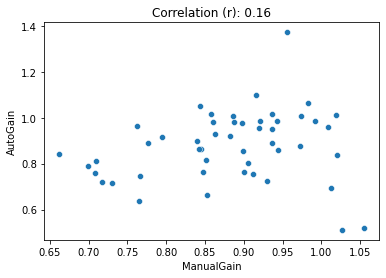

In [71]:
correlation_coef = ComTwoHCPD['ManualGain'].corr(ComTwoHCPD['AutoGain'])
# Create scatter plot
import seaborn as sns
import matplotlib.pyplot as plt
plot = sns.scatterplot(x='ManualGain', y='AutoGain', data=ComTwoHCPD)
plot.set_title(f'Correlation (r): {correlation_coef:.2f}')

# Display the plot
plt.show()